In [1]:
import torch
import deep.model as models
import deep.training as training
import pandas as pd
from tool.preprocessing import DataCollection
from tool.create_dataset import creation
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

c:\Users\Leonardo\anaconda3\envs\generic\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Hyperparameters
NUM_RECORD = 20
TOTAL_DIMENSION = NUM_RECORD*6
PROB = 1
BATCH_SIZE=64
NUM_HIDDEN = 1500
LR=5e-5
NUM_EPOCHS = 500

#Data Loader
collection = DataCollection(drop_null=True)
gt = collection.get_gt()

X = torch.tensor([]).to(torch.device("cuda:0"))
y = torch.tensor([]).to(torch.device("cuda:0"))

'''
In this part, instead of I have done before, I compute for each device (aligned to hours) the relative ground truth value.
Then I spilt the result into subsequent interval of values and linearize it.
I do this for every device in order to have a dataset of record in which each of those aren't related to anything else.
In the version one I simply take the first part of the dataset as train and the second as test, that obviously is wrong.
'''
for i in collection.get_devices():
    tmp = pd.merge(i,gt,how="inner",on="valid_at").rename(columns={"pm2p5_y":"pm2p5_t","pm2p5_x":"pm2p5"})
    res = creation(tmp,lookback=NUM_RECORD,p=1)
    X = torch.concat([X.clone(),res[0].flatten(-2)])
    y = torch.concat((y.clone(),res[1].flatten(-2)[:,0]))

In [ ]:
import torch
import numpy as np
import torch.nn as nn

import torch.optim as optim
import torch.utils.data as data
from sklearn.metrics import r2_score




device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Training
model = models.AirMLP_6(num_fin=TOTAL_DIMENSION,num_hidden=NUM_HIDDEN).to(device)
#loss_fn = nn.MSELoss(reduction='mean').to(device)
loss_fn = nn.L1Loss().to(device)
optimizer = optim.RAdam(model.parameters(), lr=LR)
loss_eval = nn.L1Loss().to(device)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=BATCH_SIZE)
loader_test = data.DataLoader(data.TensorDataset(X_test, y_test), shuffle=False, batch_size=BATCH_SIZE)
tr_loss = list()
ts_loss = list()
r2test = list()
try:
    for epoch in range(NUM_EPOCHS):
        
        model.train()
        for X_batch, y_batch in loader:
            
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()

            y_pred = model(X_batch)
            #print(y_pred.shape)
            loss = loss_fn(y_pred, y_batch)
            #print(y_batch.shape, y_pred.shape)
            
            loss.backward()

            optimizer.step()
        
        model.eval()
        
        pred_train = model(X_train)
        pred_test = model(X_test)
        tr = loss_eval(pred_train,y_train)
        ts = loss_eval(pred_test,y_test)

        tr_loss.append(tr.cpu().detach().numpy())
        ts_loss.append(ts.cpu().detach().numpy())
        r2_test = r2_score(y_test.cpu().detach().numpy(),pred_test.cpu().detach().numpy())
        r2test.append(r2_test)
        # Validation
        if epoch % 2 != 0:
            continue
        
        print(f"Epoch {epoch:3d} train mse.: {tr:.3f} test mse.: {ts:.3f} || R-2 on test: {r2_test:.3f}")
except KeyboardInterrupt:
    model.eval()
    pred_train = model(X_train)
    pred_test = model(X_test)
    tr_lss = loss_eval(pred_train,y_train)
    ts_lss = loss_eval(pred_test,y_test)
    r2_test = r2_score(y_test.cpu().detach().numpy(),pred_test.cpu().detach().numpy())
    r2test.append(r2_test)
    print(f"Epoch {epoch:3d} train L1.: {tr_lss:.3f} test L1.: {ts_lss:.3f} || R-2 on test: {r2_test:.3f}")
    NUM_EPOCHS_DONE = epoch
    

plt.plot(tr_loss,'-g', label="Train loss,MSE")
plt.plot(ts_loss,'-b', label="Test loss,MSE")
leg = plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.show()

plt.plot(r2test,'-g', label="R2 test")
plt.xlabel("Epoch")
plt.ylabel("R2 Value")
leg = plt.legend(loc='lower right')
plt.show()

In [3]:
PATH_MODEL = r'./weights_airmlp1700.pth'

In [ ]:
torch.save(model,PATH_MODEL)

In [4]:
device = torch.device("cuda:0")
model_rest = models.AirMLP_7(num_fin=TOTAL_DIMENSION,num_hidden=NUM_HIDDEN).to(device)
model_rest = torch.load(PATH_MODEL)
model_rest.eval()

AirMLP_7(
  (net): Sequential(
    (0): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=120, out_features=1500, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1500, out_features=1500, bias=True)
    (4): ReLU()
    (5): Linear(in_features=1500, out_features=1500, bias=True)
    (6): ReLU()
    (7): Linear(in_features=1500, out_features=1500, bias=True)
    (8): ReLU()
    (9): Linear(in_features=1500, out_features=1500, bias=True)
    (10): ReLU()
    (11): Linear(in_features=1500, out_features=1500, bias=True)
    (12): ReLU()
    (13): Linear(in_features=1500, out_features=1, bias=True)
  )
)

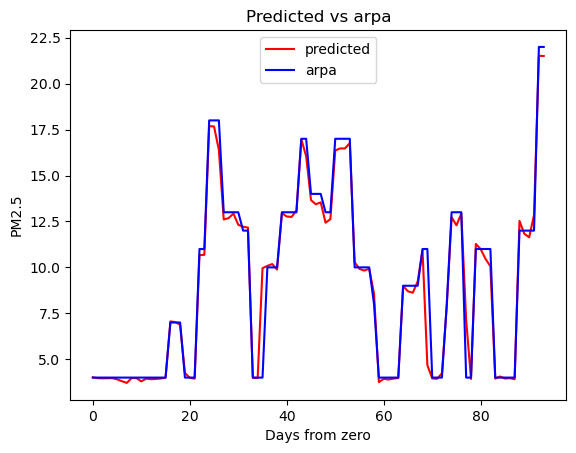

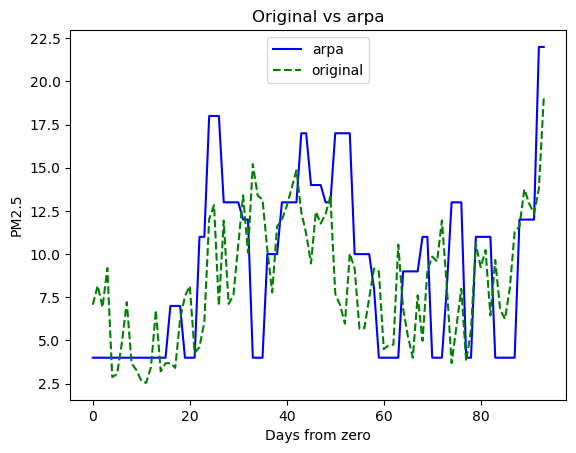

In [5]:
#drop columns
model = model_rest
test_graph = pd.read_csv(r'.\data\test_graph.csv').reset_index(drop=True)
#round.h
test_graph["valid_at"]= pd.to_datetime(test_graph["valid_at"]).dt.round("H")

#merge with arpa
tmp = pd.merge(test_graph,collection.arpa,how="inner", on="valid_at").rename(columns={"pm2p5_y":"pm2p5_t","pm2p5_x":"pm2p5"})
#create dataset
res = creation(tmp,lookback=NUM_RECORD,p=1)
X_graph = res[0].flatten(-2)
y_arpa = res[1].flatten(-2)[:,0]
#model
model.eval()
y_res = model(X_graph)
#plot





plt.title(f"Predicted vs arpa")

plt.plot(y_res.cpu().detach().numpy(),'-r', label="predicted")
plt.plot(y_arpa.cpu().detach().numpy(),'-b', label="arpa")
leg = plt.legend(loc='upper center')
plt.xlabel('Days from zero')
plt.ylabel('PM2.5')

plt.show()



plt.title(f"Original vs arpa")
plt.plot(y_arpa.cpu().detach().numpy(),'-b', label="arpa")
plt.plot(test_graph["pm2p5"][20:].reset_index(drop=True),'--g', label="original")
leg = plt.legend(loc='upper center')
plt.xlabel('Days from zero')
plt.ylabel('PM2.5')




plt.show()

In [ ]:
import numpy as np

plt.scatter(y_res.cpu().detach().numpy(), y_arpa.cpu().detach().numpy(), alpha=0.5)
plt.show()

In [6]:
test_graph["pm2p5"].shape

(114,)

In [7]:
y_arpa.shape

torch.Size([94])

In [1]:
import pandas as pd
from tool.preprocessing import DataCollection
from tool.create_dataset import creation
import matplotlib.pyplot as plt

c:\Users\Leonardo\anaconda3\envs\generic\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
collection = DataCollection(drop_null=False)

In [6]:
collection.ari1952["valid_at"]= pd.to_datetime(collection.ari1952["valid_at"]).dt.round("H")

#merge with arpa
tmp = pd.merge(collection.ari1952,collection.arpa,how="inner", on="valid_at").rename(columns={"pm2p5_y":"pm2p5_t","pm2p5_x":"pm2p5"})

In [7]:
tmp

,valid_at,relative_humidity,temperature,pressure,wind_speed,cloud_coverage,pm2p5,pm2p5_t
0,2022-03-01 01:00:00,50.0,5.68,1028.0,4.63,0.0,20.09,26.0
1,2022-03-01 01:00:00,50.0,5.68,1028.0,4.63,0.0,20.17,26.0
2,2022-03-01 01:00:00,55.0,5.10,1029.0,3.13,0.0,19.04,26.0
3,2022-03-01 02:00:00,55.0,5.10,1029.0,3.13,0.0,22.77,23.0
4,2022-03-01 02:00:00,55.0,5.10,1029.0,3.13,0.0,12.89,23.0
...,...,...,...,...,...,...,...,...
3793,2022-04-28 04:00:00,63.0,13.66,1023.0,1.79,39.0,13.60,16.0
3794,2022-04-28 05:00:00,63.0,13.66,1023.0,1.79,39.0,14.41,10.0
3795,2022-04-28 05:00:00,64.0,13.14,1023.0,2.57,40.0,17.34,10.0
3796,2022-04-28 06:00:00,64.0,13.14,1023.0,2.57,40.0,17.21,13.0


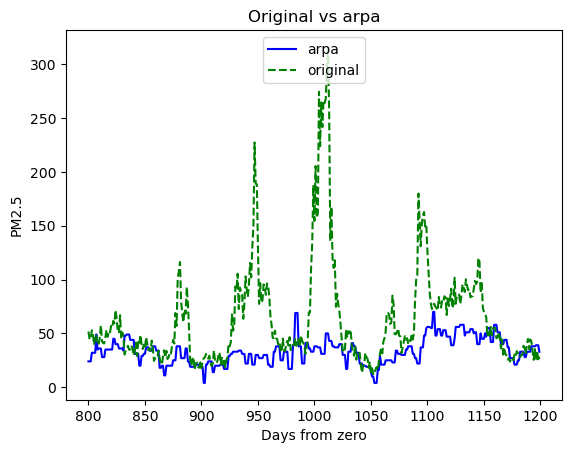

In [11]:
plt.title(f"Original vs arpa")
plt.plot(tmp["pm2p5_t"][800:1200],'-b', label="arpa")
plt.plot(tmp["pm2p5"][800:1200],'--g', label="original")
leg = plt.legend(loc='upper center')
plt.xlabel('Days from zero')
plt.ylabel('PM2.5')




plt.show()